In [1]:
""" Programmet är avsett att köras kl. 05:00 varje dag. 
Detta hanteras bäst genom en schemaläggare, såsom cron eller Windows Task Scheduler."""



' Programmet är avsett att köras kl. 05:00 varje dag. \nDetta hanteras bäst genom en schemaläggare, såsom cron eller Windows Task Scheduler.'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Ladda  data
filväg = "lagerstatus.csv"
data = pd.read_csv(filväg)

print("Data läst in: ")
print(data.head)

# Beräkna totalvikten (Kontroll för mig själv!!)
total_vikt = data['Vikt'].sum()
print(f"Den totala vikten av alla paket är: {total_vikt} kg")

print("Data översikt:")
print(data.describe())

Data läst in: 
<bound method NDFrame.head of         Paket_id  Vikt  Förtjänst  Deadline
0     2241323127   8.6          8        -4
1     2241323130   2.4          5         6
2     2241323133   9.2          1         1
3     2241323139   5.1          5         2
4     2241323140   3.0          1         5
...          ...   ...        ...       ...
9995  2241358206   1.6          7         1
9996  2241358208   4.2          5         1
9997  2241358213   3.0          5         3
9998  2241358215  10.6          5         7
9999  2241358221   1.4          3         2

[10000 rows x 4 columns]>
Den totala vikten av alla paket är: 51224.2 kg
Data översikt:
           Paket_id          Vikt     Förtjänst      Deadline
count  1.000000e+04  10000.000000  10000.000000  10000.000000
mean   2.241341e+09      5.122420      4.913700      3.771000
std    1.010311e+04      3.562051      2.380802      3.554887
min    2.241323e+09      0.100000      1.000000     -5.000000
25%    2.241332e+09      1.9

In [3]:
# funktion för att utvärdera en lösning,
# Genom att beräkna maximera förtjänstvärdet av levererade paket,
# beräkna minimera starffavgifter för paket som inte levereras i tid.
# Även säkerställa att varje bil inte överstiger sin maxvikt.
# så fitness visas Högre värde är lika med mer förtjänst, färre starffavgift 
# Lägre värde är Fler straffavgifter, sämre tilldelning

def beräkna_fitness(lösning, data, max_vikt):
    bilar = {f"bil_{i+1}": {"vikt": 0, "förtjänst": 0} for i in range(10)}
    kvarvarande_paket = []

    for paket_id, bil_id in enumerate(lösning):
        paket = data.iloc[paket_id]
        if bilar[f"bil_{bil_id}"]["vikt"] + paket["Vikt"] <= max_vikt:
            bilar[f"bil_{bil_id}"]["vikt"] += paket["Vikt"]
            bilar[f"bil_{bil_id}"]["förtjänst"] += paket["Förtjänst"]
        else:
            kvarvarande_paket.append(paket)

    total_förtjänst = sum(bil["förtjänst"] for bil in bilar.values())
    straffavgift = sum((max(0, -paket["Deadline"]) ** 2) for paket in kvarvarande_paket)
    return total_förtjänst - straffavgift

In [4]:
# Skapar en initial population av lösningar
# En lista av slunmpmässiga lösningar, som är en lista som anger vilken bil varje paket tilldelas.
def initiera_population(data, antal_lösningar):
    return [
        [random.randint(1, 10) for _ in range(len(data))]
        for _ in range(antal_lösningar)
    ]

In [5]:
# Korsning mellan två lösningar
# blandra två lösningar för att skapa nya lösningar med kombinerade egenskaper.
def korsning(lösning1, lösning2):
    punkt = random.randint(1, len(lösning1) - 1)
    ny_lösning1 = lösning1[:punkt] + lösning2[punkt:]
    ny_lösning2 = lösning2[:punkt] + lösning1[punkt:]
    return ny_lösning1, ny_lösning2


In [6]:
# Mutation av en lösning
# Gör små förändringar i lösningar för att undvika att fastna i lokala optima.
def mutation(lösning, mutation_sannolikhet=0.1):
    for i in range(len(lösning)):
        if random.random() < mutation_sannolikhet:
            lösning[i] = random.randint(1, 10)
    return lösning

In [7]:
# Genetisk algoritm
# Optimerar pakettilldelningen genom att iterativt förbättra lösningar.
def genetisk_algoritm(data, max_vikt, generationer=100, population_size=50, stopp_tolerans=10):
   
    population = initiera_population(data, population_size)
    bäst_fitness_historik = []  # Spårar bästa fitness för varje generation
    ingen_förbättring = 0
    bästa_fitness = float('-inf')

    for generation in range(generationer):
        # Beräkna fitness för alla lösningar
        fitness = [beräkna_fitness(lösning, data, max_vikt) for lösning in population]

        # Välj de bästa lösningarna
        sorterade = sorted(zip(population, fitness), key=lambda x: x[1], reverse=True)
        population = [lösning for lösning, _ in sorterade[:population_size // 2]]

        # Spåra bästa fitness
        nuvarande_bästa_fitness = max(fitness)
        bäst_fitness_historik.append(nuvarande_bästa_fitness)

        # Kontrollera förbättringar
        if nuvarande_bästa_fitness > bästa_fitness:
            bästa_fitness = nuvarande_bästa_fitness
            # Återställ räkning av uteblivna förbättringar
            ingen_förbättring = 0
        else:
            ingen_förbättring += 1

        # Stoppkriterium
        if ingen_förbättring >= stopp_tolerans:
            print(f"Stoppkriterium uppfyllt efter {generation+1} generationer.")
            break

        # Skapa ny generation
        ny_population = []
        while len(ny_population) < population_size:
            förälder1, förälder2 = random.sample(population, 2)
            barn1, barn2 = korsning(förälder1, förälder2)
            ny_population.append(mutation(barn1))
            ny_population.append(mutation(barn2))
        population = ny_population

    bästa_lösning = max(population, key=lambda lösning: beräkna_fitness(lösning, data, max_vikt))
    return bästa_lösning, bästa_fitness, bäst_fitness_historik


In [9]:
# Kör genetisk algoritm
bästa_lösning, bästa_fitness, bäst_fitness_historik = genetisk_algoritm(
    data, max_vikt=800, generationer=5, population_size=30, stopp_tolerans=10
)

print(f"Bästa fitness: {bästa_fitness}")
print(f"Bästa lösning (pakettilldelning): {bästa_lösning}")



Bästa fitness: -1098.0
Bästa lösning (pakettilldelning): [5, 2, 3, 2, 6, 3, 5, 6, 10, 8, 9, 2, 9, 7, 1, 9, 7, 5, 8, 4, 9, 10, 2, 2, 3, 8, 2, 1, 2, 9, 5, 7, 1, 9, 7, 5, 2, 2, 9, 4, 6, 2, 9, 5, 8, 7, 10, 7, 4, 8, 5, 8, 10, 8, 9, 9, 1, 3, 8, 6, 1, 10, 2, 9, 7, 8, 8, 10, 2, 1, 8, 6, 7, 4, 5, 8, 1, 8, 5, 1, 3, 10, 8, 4, 5, 9, 6, 2, 6, 6, 5, 10, 1, 5, 10, 6, 6, 8, 6, 2, 5, 8, 5, 1, 10, 1, 8, 7, 5, 9, 6, 2, 8, 2, 6, 8, 2, 5, 1, 5, 1, 6, 2, 6, 6, 2, 9, 9, 1, 5, 8, 10, 9, 3, 6, 6, 8, 7, 6, 1, 2, 10, 6, 8, 9, 1, 7, 10, 3, 10, 3, 8, 4, 7, 10, 6, 6, 9, 2, 4, 1, 10, 1, 6, 9, 9, 2, 10, 1, 4, 10, 4, 2, 2, 9, 2, 6, 6, 9, 5, 4, 9, 8, 2, 10, 4, 8, 3, 3, 10, 4, 2, 5, 1, 4, 8, 8, 6, 8, 9, 5, 1, 6, 8, 5, 4, 5, 3, 7, 5, 1, 8, 2, 5, 2, 2, 3, 9, 2, 4, 3, 6, 9, 5, 2, 1, 10, 5, 7, 5, 1, 1, 6, 4, 1, 6, 7, 6, 8, 9, 4, 6, 4, 1, 2, 10, 7, 6, 4, 1, 2, 4, 1, 10, 8, 7, 3, 3, 7, 7, 3, 6, 6, 7, 2, 2, 9, 5, 2, 4, 6, 5, 8, 6, 5, 3, 7, 5, 5, 5, 1, 2, 5, 5, 3, 1, 2, 2, 6, 9, 10, 8, 7, 7, 4, 5, 4, 2, 8, 1, 8, 8, 3, 5, 9, 8, 

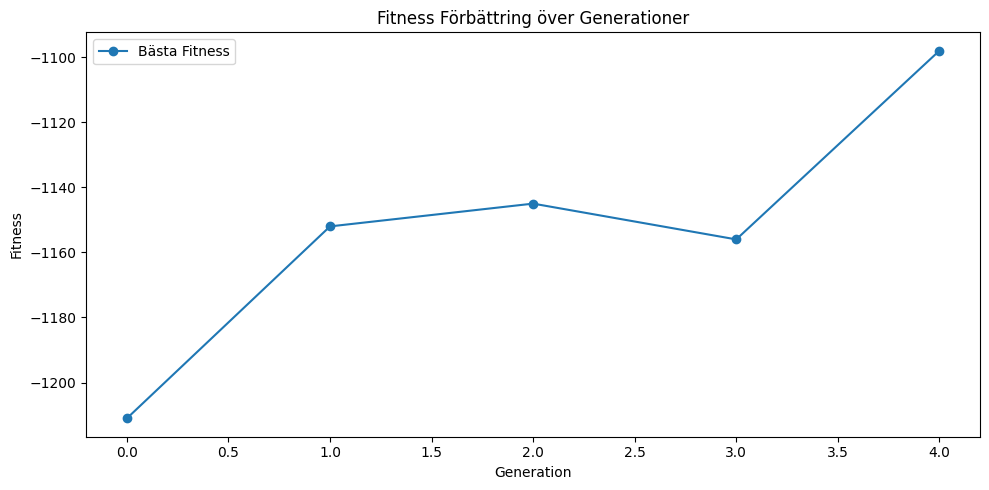

Bästa fitness: -1098.0
Bästa lösning (pakettilldelning): [5, 2, 3, 2, 6, 3, 5, 6, 10, 8, 9, 2, 9, 7, 1, 9, 7, 5, 8, 4, 9, 10, 2, 2, 3, 8, 2, 1, 2, 9, 5, 7, 1, 9, 7, 5, 2, 2, 9, 4, 6, 2, 9, 5, 8, 7, 10, 7, 4, 8, 5, 8, 10, 8, 9, 9, 1, 3, 8, 6, 1, 10, 2, 9, 7, 8, 8, 10, 2, 1, 8, 6, 7, 4, 5, 8, 1, 8, 5, 1, 3, 10, 8, 4, 5, 9, 6, 2, 6, 6, 5, 10, 1, 5, 10, 6, 6, 8, 6, 2, 5, 8, 5, 1, 10, 1, 8, 7, 5, 9, 6, 2, 8, 2, 6, 8, 2, 5, 1, 5, 1, 6, 2, 6, 6, 2, 9, 9, 1, 5, 8, 10, 9, 3, 6, 6, 8, 7, 6, 1, 2, 10, 6, 8, 9, 1, 7, 10, 3, 10, 3, 8, 4, 7, 10, 6, 6, 9, 2, 4, 1, 10, 1, 6, 9, 9, 2, 10, 1, 4, 10, 4, 2, 2, 9, 2, 6, 6, 9, 5, 4, 9, 8, 2, 10, 4, 8, 3, 3, 10, 4, 2, 5, 1, 4, 8, 8, 6, 8, 9, 5, 1, 6, 8, 5, 4, 5, 3, 7, 5, 1, 8, 2, 5, 2, 2, 3, 9, 2, 4, 3, 6, 9, 5, 2, 1, 10, 5, 7, 5, 1, 1, 6, 4, 1, 6, 7, 6, 8, 9, 4, 6, 4, 1, 2, 10, 7, 6, 4, 1, 2, 4, 1, 10, 8, 7, 3, 3, 7, 7, 3, 6, 6, 7, 2, 2, 9, 5, 2, 4, 6, 5, 8, 6, 5, 3, 7, 5, 5, 5, 1, 2, 5, 5, 3, 1, 2, 2, 6, 9, 10, 8, 7, 7, 4, 5, 4, 2, 8, 1, 8, 8, 3, 5, 9, 8, 

In [10]:
# Visualisera förbättring över generationer
plt.figure(figsize=(10, 5))
plt.plot(bäst_fitness_historik, marker='o', label='Bästa Fitness')
plt.title('Fitness Förbättring över Generationer')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.tight_layout()
plt.show()

# Visa bästa lösningen
print(f"Bästa fitness: {bästa_fitness}")
print(f"Bästa lösning (pakettilldelning): {bästa_lösning}")



In [12]:
# Beräkna justerad förtjänst och förtjänst per vikt
def optimera_bilar(data, max_vikt=800, antal_bilar=10):
    data['Justerad_Förtjänst'] = data['Förtjänst'] - (np.maximum(0, -data['Deadline']) ** 2)
    data['Förtjänst_Per_Vikt'] = data['Justerad_Förtjänst'] / data['Vikt']
    data = data.sort_values(by='Förtjänst_Per_Vikt', ascending=False)

    # Initiera bilar med tm vikt och paketlista
    bilar = {f"bil_{i+1}": {"vikt": 0, "paket": []} for i in range(antal_bilar)}
    kvarvarande_paket = []

    # Tilldela oaket till bilar
    for _, paket in data.iterrows():
        tilldelad = False
        for bil in bilar.values():
            if bil["vikt"] + paket['Vikt'] <= max_vikt:
                bil["paket"].append(paket.to_dict())  # Sparar paket som dictionary
                bil["vikt"] += paket['Vikt']
                tilldelad = True
                break
        if not tilldelad:
            kvarvarande_paket.append(paket.to_dict())

    return bilar, pd.DataFrame(kvarvarande_paket)

# Kör optimeringen
bilar, kvarvarande = optimera_bilar(data, max_vikt=800, antal_bilar=10)
print("Optimering klar!")

# skriver ut resultat för varje bilar
for bil_id, bil in bilar.items():
    print(f"{bil_id}: Vikt = {bil['vikt']} kg, Antal paket = {len(bil['paket'])}")

# Kontrollera om paket finns kvar
if not kvarvarande.empty:
    print(f"Kvarvarande paket: {len(kvarvarande)}")
else:
    print("Inga paket kvar i lager.")


Optimering klar!
bil_1: Vikt = 799.9999999999995 kg, Antal paket = 1208
bil_2: Vikt = 799.9000000000013 kg, Antal paket = 567
bil_3: Vikt = 799.9999999999998 kg, Antal paket = 406
bil_4: Vikt = 799.9000000000003 kg, Antal paket = 352
bil_5: Vikt = 799.999999999997 kg, Antal paket = 311
bil_6: Vikt = 799.900000000003 kg, Antal paket = 301
bil_7: Vikt = 799.9999999999998 kg, Antal paket = 260
bil_8: Vikt = 799.9000000000003 kg, Antal paket = 241
bil_9: Vikt = 799.9000000000007 kg, Antal paket = 208
bil_10: Vikt = 799.9000000000002 kg, Antal paket = 201
Kvarvarande paket: 5945


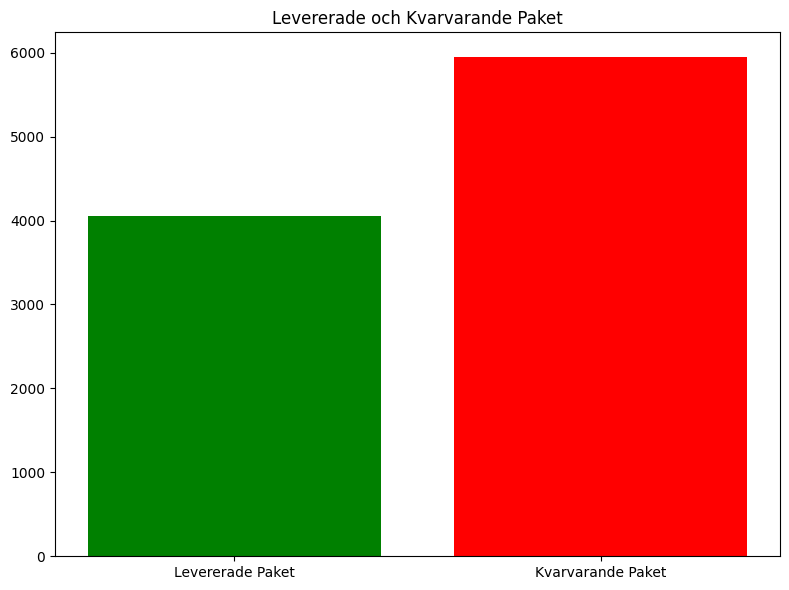

In [16]:
#Levereade och kvarvarande paket
plt.figure(figsize=(8, 6))
plt.bar(['Levererade Paket', 'Kvarvarande Paket'], [len(data) - len(kvarvarande), len(kvarvarande)], color=['green', 'red'])
plt.title('Levererade och Kvarvarande Paket')
plt.tight_layout()
plt.show()

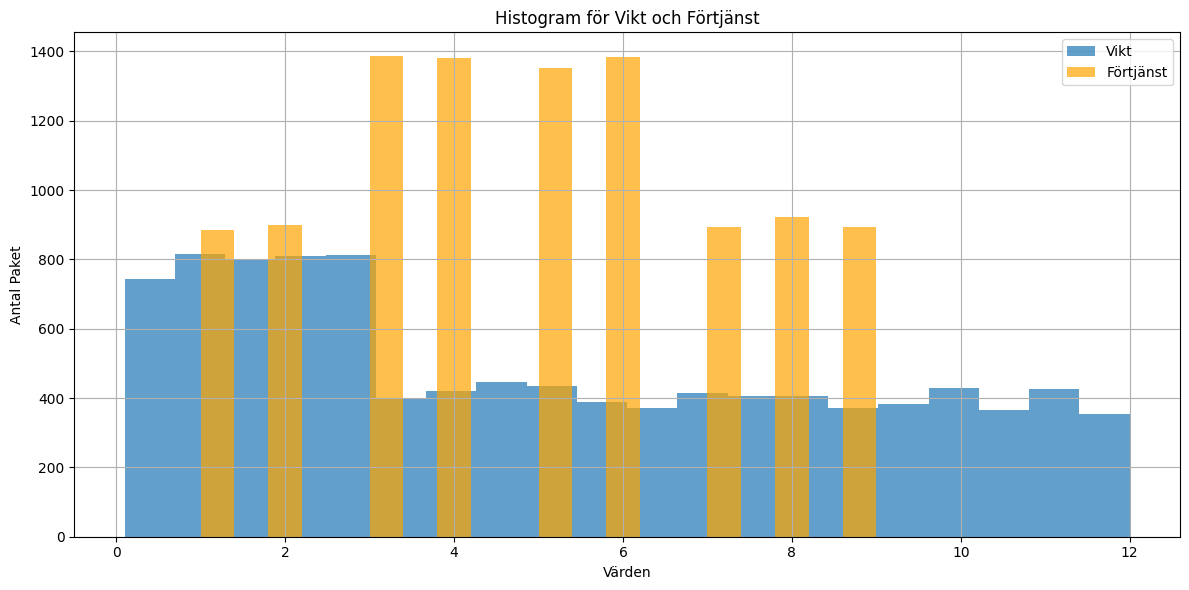

In [15]:
# Visualisera histogram
plt.figure(figsize=(12, 6))
data['Vikt'].hist(bins=20, alpha=0.7, label="Vikt")
data['Förtjänst'].hist(bins=20, alpha=0.7, label="Förtjänst", color='orange')
plt.title("Histogram för Vikt och Förtjänst")
plt.xlabel("Värden")
plt.ylabel("Antal Paket")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Statistikfunktion
# Beräkna total förtjänst från alla levererade paket
def beräkna_statistik(bilar, kvarvarande):
    total_förtjänst = sum(
        sum(paket['Justerad_Förtjänst'] for paket in bil["paket"])
        for bil in bilar.values()
    )
    # Justera förtjänst för kvarvarande paket vaserat på deadline
    if not kvarvarande.empty:
        kvarvarande['Justerad_Förtjänst'] = kvarvarande.apply(
            lambda rad: rad['Förtjänst'] - (np.maximum(0, -rad['Deadline']) ** 2), axis=1
        )
        # Beräkna total straffavgift för kvarvarande paket
        total_straffavgift = kvarvarande.apply(
            lambda rad: np.maximum(0, -rad['Deadline']) ** 2, axis=1
        ).sum()
        # Beräkna total förtjänst kvar i lager
        kvarvarande_förtjänst = kvarvarande['Justerad_Förtjänst'].sum()
    else:
        total_straffavgift = 0
        kvarvarande_förtjänst = 0

    print(f"Total Förtjänst för leveranser: {total_förtjänst}")
    print(f"Total Straffavgift för kvarvarande paket: {total_straffavgift}")
    print(f"Antal paket kvar i lager: {len(kvarvarande)}")
    print(f"Total förtjänst kvar i lager: {kvarvarande_förtjänst}")

beräkna_statistik(bilar, kvarvarande)

Total Förtjänst för leveranser: 22400.0
Total Straffavgift för kvarvarande paket: 10690.0
Antal paket kvar i lager: 5945
Total förtjänst kvar i lager: 15830.0


Statistik för paket i lager:
Medelvikt: 7.270782169890665 kg
Standardavvikelse: 2.9412299452209676 kg
Medelförtjänst: 4.460891505466779
Varians förtjänst: 6.447031843038531


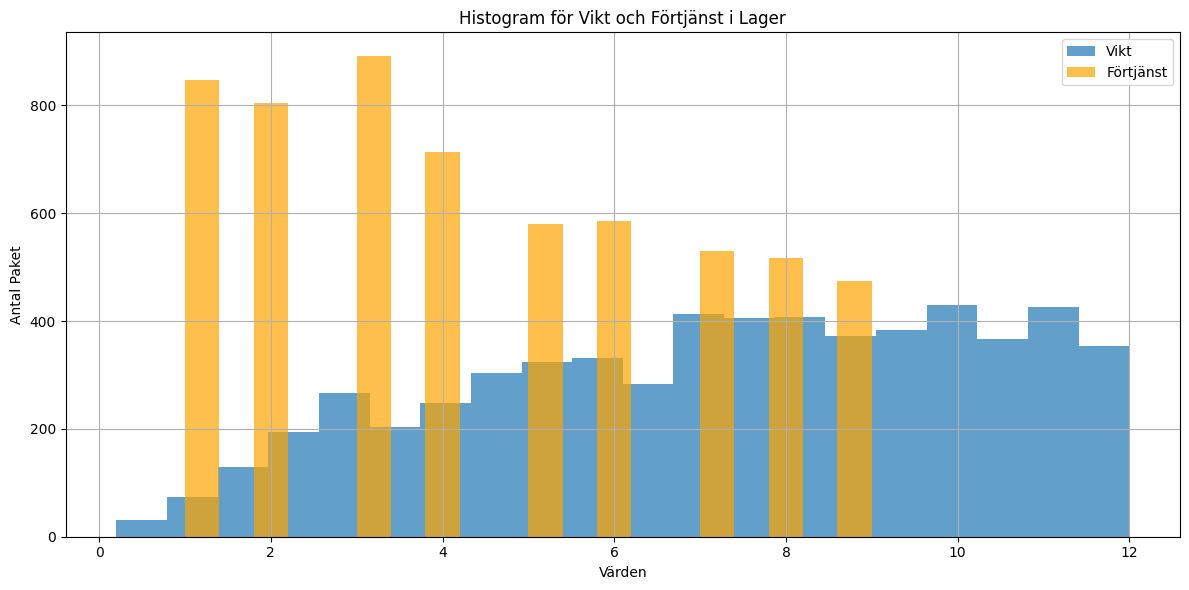

In [18]:
# Statistik och histogram
print("Statistik för paket i lager:")
if not kvarvarande.empty:
    print(f"Medelvikt: {kvarvarande['Vikt'].mean()} kg")
    print(f"Standardavvikelse: {kvarvarande['Vikt'].std()} kg")
    print(f"Medelförtjänst: {kvarvarande['Förtjänst'].mean()}")
    print(f"Varians förtjänst: {kvarvarande['Förtjänst'].var()}")

    plt.figure(figsize=(12, 6))
    kvarvarande['Vikt'].hist(bins=20, alpha=0.7, label="Vikt")
    kvarvarande['Förtjänst'].hist(bins=20, alpha=0.7, label="Förtjänst", color='orange')
    plt.title("Histogram för Vikt och Förtjänst i Lager")
    plt.xlabel("Värden")
    plt.ylabel("Antal Paket")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Inga paket kvar i lager att analysera.")

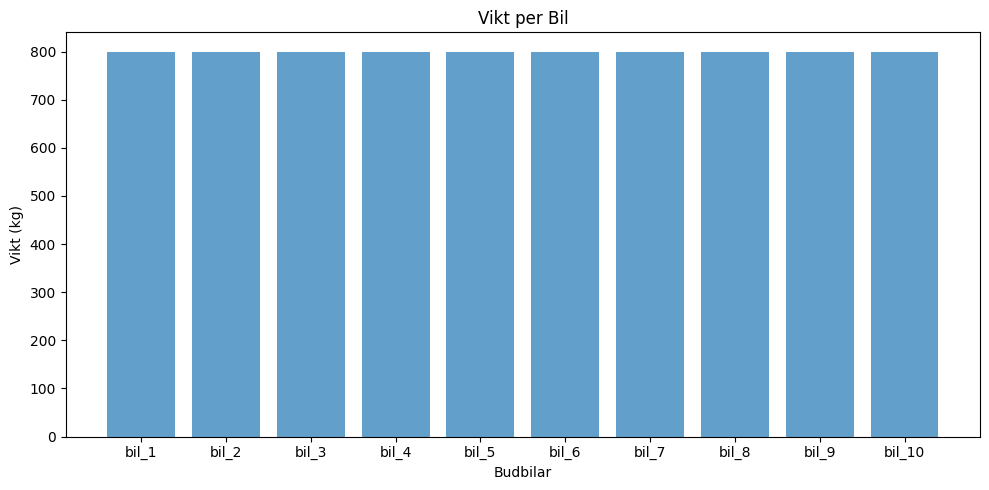

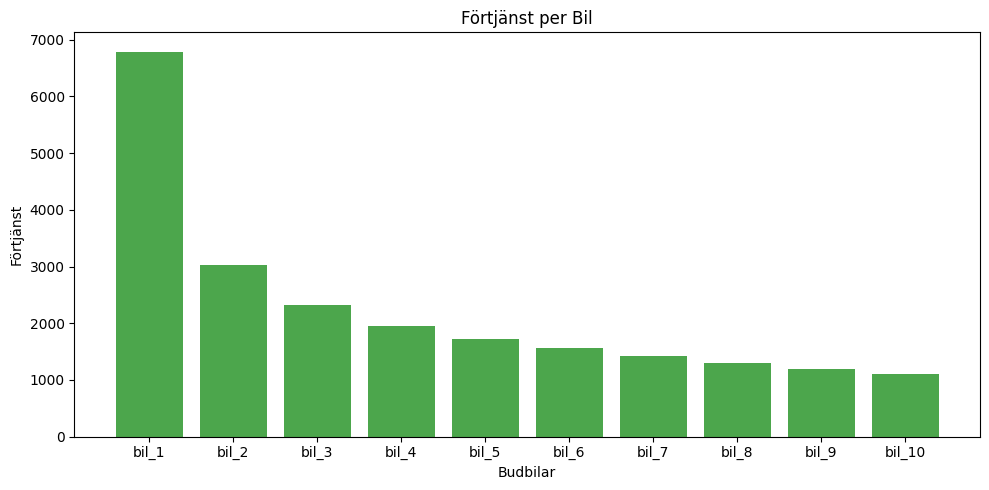

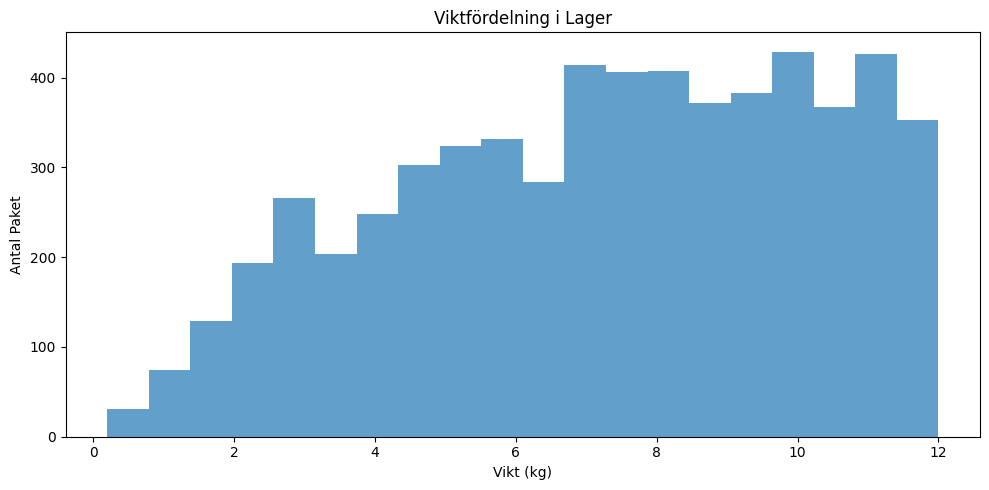

In [19]:
# Visualisera vikt och förtjänst per bil
def plotta_resultat(bilar, kvarvarande):
    bil_idn = list(bilar.keys())
    total_vikter = [sum(paket['Vikt'] for paket in bil["paket"]) for bil in bilar.values()]
    total_förtjänster = [sum(paket['Justerad_Förtjänst'] for paket in bil["paket"]) for bil in bilar.values()]

    # Stapeldiagram för vikt och förtjänst
    plt.figure(figsize=(10, 5))
    plt.bar(bil_idn, total_vikter, alpha=0.7)
    plt.title('Vikt per Bil')
    plt.xlabel('Budbilar')
    plt.ylabel('Vikt (kg)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(bil_idn, total_förtjänster, alpha=0.7, color='green')
    plt.title('Förtjänst per Bil')
    plt.xlabel('Budbilar')
    plt.ylabel('Förtjänst')
    plt.tight_layout()
    plt.show()

    if not kvarvarande.empty:
        plt.figure(figsize=(10, 5))
        plt.hist(kvarvarande['Vikt'], bins=20, alpha=0.7)
        plt.title('Viktfördelning i Lager')
        plt.xlabel('Vikt (kg)')
        plt.ylabel('Antal Paket')
        plt.tight_layout()
        plt.show()

plotta_resultat(bilar, kvarvarande)

Statistik för paket:
Medelvikt: 5.12242 kg
Standardavvikelse: 3.5620505560724993 kg
Medelförtjänst: 4.9137
Varians förtjänst: 5.668219131913192


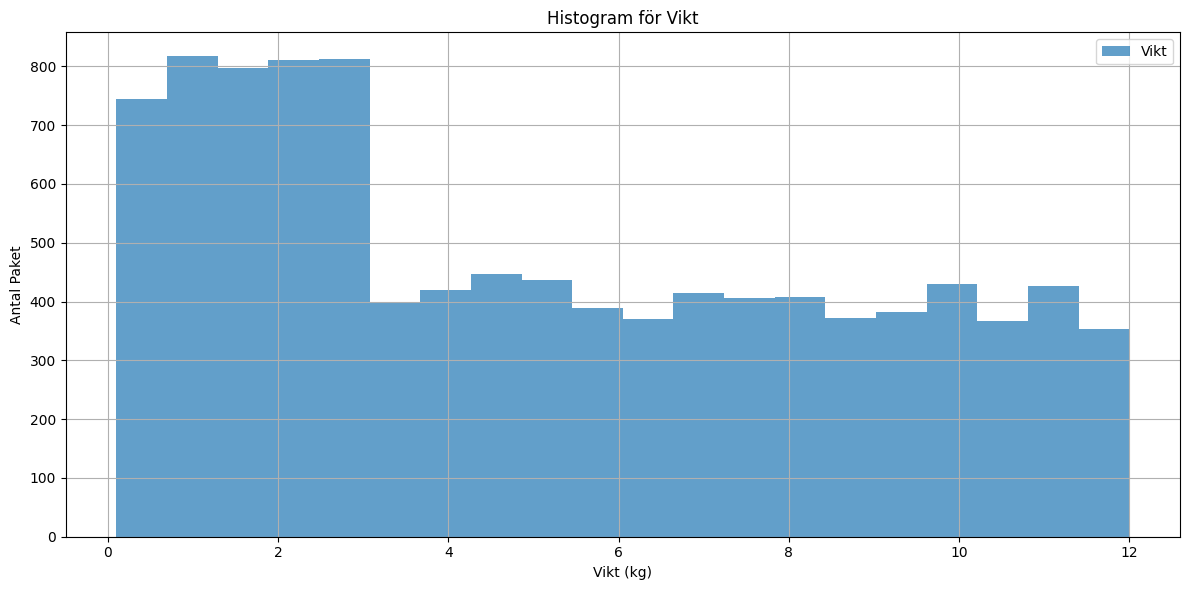

In [20]:
# Statistik och histogram
print("Statistik för paket:")
print(f"Medelvikt: {data['Vikt'].mean()} kg")
print(f"Standardavvikelse: {data['Vikt'].std()} kg")
print(f"Medelförtjänst: {data['Förtjänst'].mean()}")
print(f"Varians förtjänst: {data['Förtjänst'].var()}")

plt.figure(figsize=(12, 6))
data['Vikt'].hist(bins=20, alpha=0.7, label="Vikt")
plt.title("Histogram för Vikt")
plt.xlabel("Vikt (kg)")
plt.ylabel("Antal Paket")
plt.legend()
plt.tight_layout()
plt.show()

Total förtjänst: 22400.0, Total straffavgift: 10690.0


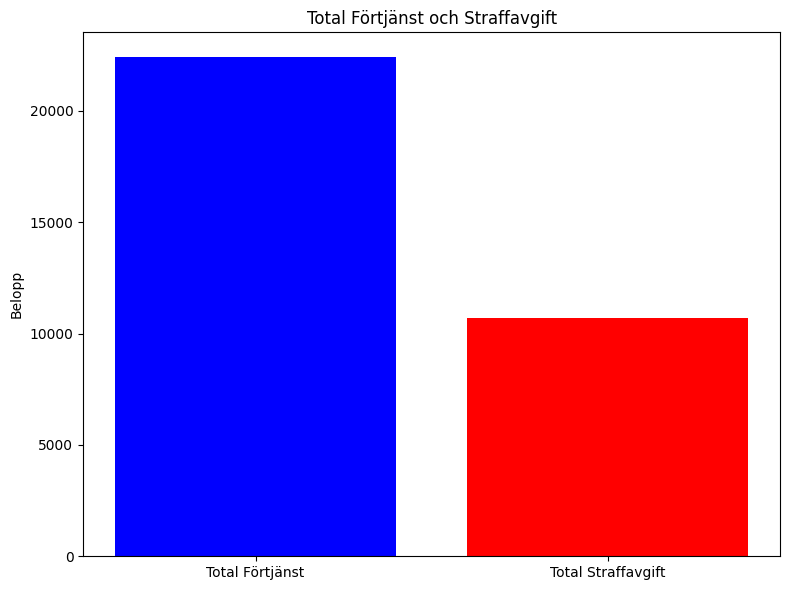

In [21]:
# Beräkna total förtjänst och total straffavgift
total_förtjänst = sum(
    sum(paket['Justerad_Förtjänst'] for paket in bil["paket"])
    for bil in bilar.values()
)

# Summera straffavgifterna för kvarvarande paket
if not kvarvarande.empty:  # Kontrollera om det finns några kvarvarande paket
    total_straffavgift = kvarvarande.apply(
        lambda rad: np.maximum(0, -rad['Deadline']) ** 2, axis=1
    ).sum()
else:
    total_straffavgift = 0

# Kontrollera att värdena är numeriska
print(f"Total förtjänst: {total_förtjänst}, Total straffavgift: {total_straffavgift}")

# Skapa diagram
plt.figure(figsize=(8, 6))
plt.bar(['Total Förtjänst', 'Total Straffavgift'], [total_förtjänst, total_straffavgift], color=['blue', 'red'])
plt.title('Total Förtjänst och Straffavgift')
plt.ylabel('Belopp')
plt.tight_layout()
plt.show()


Antal kvarvarande paket: 5945
Kvarvarande förtjänst: 15830.0


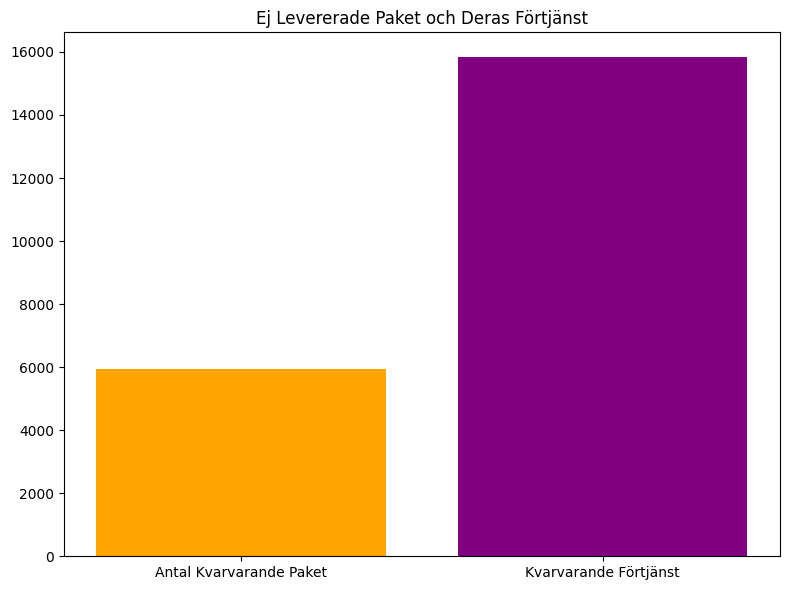

In [22]:
# Kontrollera om kvarvarande är tom
if kvarvarande.empty:
    print("Inga kvarvarande paket. Inget att analysera.")
else:
    # Kontrollera att nödvändiga kolumner finns
    if 'Förtjänst' in kvarvarande.columns and 'Deadline' in kvarvarande.columns:
        kvarvarande['Justerad_Förtjänst'] = kvarvarande.apply(
            lambda rad: rad['Förtjänst'] - (np.maximum(0, -rad['Deadline']) ** 2), axis=1
        )

        # Antal och sammanlagd förtjänst för ej levererade paket
        antal_kvarvarande = len(kvarvarande)
        kvarvarande_förtjänst = kvarvarande['Justerad_Förtjänst'].sum()

        # Kontrollera värden
        print(f"Antal kvarvarande paket: {antal_kvarvarande}")
        print(f"Kvarvarande förtjänst: {kvarvarande_förtjänst}")

        # Skapa diagram
        plt.figure(figsize=(8, 6))
        plt.bar(['Antal Kvarvarande Paket', 'Kvarvarande Förtjänst'], [antal_kvarvarande, kvarvarande_förtjänst], color=['orange', 'purple'])
        plt.title('Ej Levererade Paket och Deras Förtjänst')
        plt.tight_layout()
        plt.show()
    else:
        print("Kolumner 'Förtjänst' och 'Deadline' saknas i kvarvarande.")
